# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, a type of machine learning in which a machine learning task is addressed using multiple devices, implemented in `pytorch`, a python implementation of the `torch` machine learning framework. This notebook is part of a series intended to start from the basics to demonstrate federated learning in pytorch, then move on to test some of the bounds of what federated learning can (and can't) do.

Now, let's talk about what we're going to see in _this_ notebook.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Basics

We need to load up the common elements to be used in the traditional and federated machine learning approaches. But we do a little housekeeping first to track performance of the code.

In [1]:
import time
import datetime

run_data = {} # used for code profiling

run_data['Date'] = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
run_data['Global Start Time'] = time.time()

### The Model

Now we define the model. We're using a simple multilayer perceptron in the `torch` framework.

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set. Nothing exciting to see here. This is our baseline. 

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch the data for you.

In [3]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

Now we have our standard MNIST datasets: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

TODO: EXPLAIN WHY WE NORMALIZE THE DATA, AND WHY WE USE THOSE VALUES?

In [4]:
# create dataloaders

from torch.utils.data import DataLoader

run_data['Batch Size'] = batch_size = 256

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many `4`s as `6`s.

The training data is reasonably well distributed, and the plots below confirm it. We scaled up the test set counts by a factor of six to make them comparable to the training set, which has exactly six times as many examples as the test set.

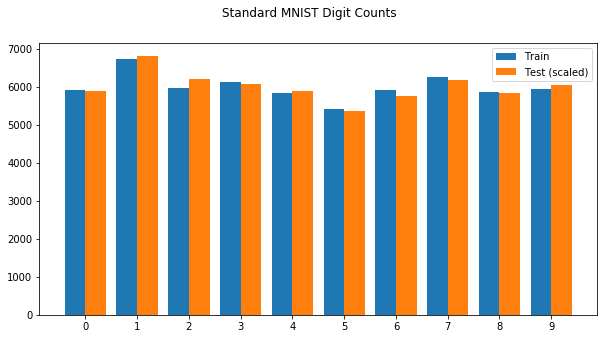

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Standard MNIST Digit Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model using just one worker (we're technically using the federated library, but with one worker, it's equivalent to non-federated learning). This one worker will train on the full standard MNIST dataset of 60,000 examples.

TODO: AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

TODO: Explain (and apologize?) the hack to measure the length of a dataset? Or find another way?

In [6]:
import federated

run_data['Learning Rate'] = learning_rate = 1e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Nonfederated Training Rounds'] = num_rounds = 3

default_manager = federated.FederatedManager(
    [train_dloader],
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

print("Dataset size: ", len(train_dloader.dataset))
    
#_, ybatches = list(zip(*train_dloader))
#print("Dataset size:", len(torch.cat(ybatches)))

Dataset size:  60000


In [7]:
from tqdm import tqdm

print("Training", num_rounds, "round(s) with", default_manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    default_manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % default_manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = default_manager.manager_loss_history
#run_data['Worker Loss Histories'] = default_manager.worker_loss_histories
run_data['Final Global Loss'] = default_manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

  0%|          | 0/3 [00:00<?, ?it/s]

Training 3 round(s) with 1 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 7112 	local loss: 2.08


 33%|███▎      | 1/3 [00:32<01:04, 32.06s/it]

Finished round 1 with global loss: 2.07815 

Beginning round 2
	Worker: 7112 	local loss: 1.57


 67%|██████▋   | 2/3 [01:00<00:31, 31.12s/it]

Finished round 2 with global loss: 1.40588 

Beginning round 3
	Worker: 7112 	local loss: 0.91


100%|██████████| 3/3 [01:32<00:00, 31.28s/it]

Finished round 3 with global loss: 0.85352 

Federated Training Time: 92.67


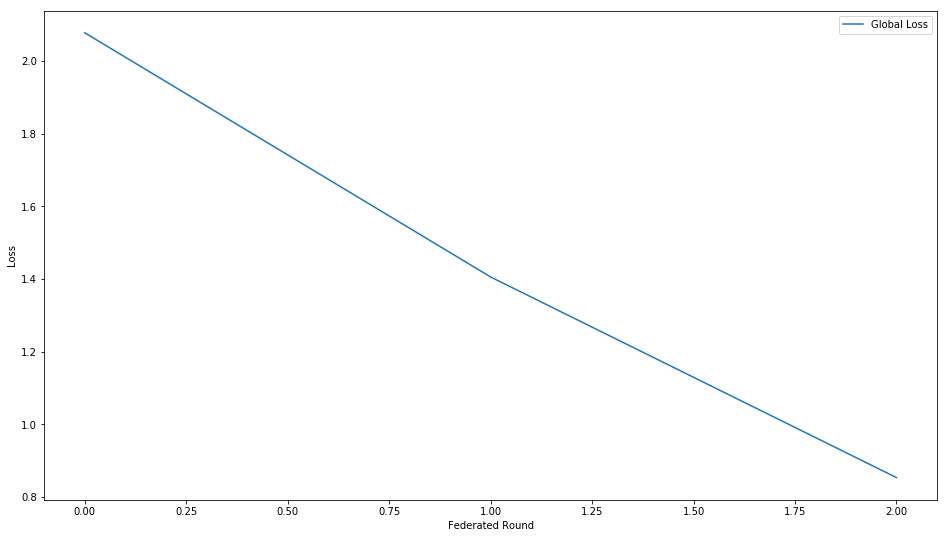

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_default, ax_default = plt.subplots(figsize=(16, 9))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax_default.plot(default_manager.manager_loss_history[1::2], label="Global Loss", )
ax_default.set_xlabel("Federated Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

## The Federated Approach

TODO: Federated learning _without_ the skew?

In [9]:
# Unskewed Federated?

## Stacking the Deck (Skewing Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [10]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
        dset: dataset
        label_weights = {dog: 0.5, cat: 0.3, ...}
        N: size of stacked dset
        return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving `3`s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on `3`s compared to everything else. In an an extreme example, preserving only `3`s, with a skew of 0, will produce weights that will yield a dataset of only `3`s.

In [11]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

Here we do the sampling to create our skewed datasets.

In [12]:
# create stacked loaders for the workers

run_data['Skew Bias'] = skew_bias = 0.05
run_data['Examples Per Skewed Loader'] = loader_size = 1000
run_data['Number of Workers'] = num_workers = 10

stacking_start_time = time.time()

stacked_data_loaders = []
for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label%10], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

run_data['Stacking Time'] = time.time() - stacking_start_time
run_data['Stacking Time per Loader'] = run_data['Stacking Time'] / run_data['Number of Workers']

print('Stacking Time: %.2f' % run_data['Stacking Time'])
print('Stacking Time per Loader: %.2f' % run_data['Stacking Time per Loader'])

100%|██████████| 10/10 [02:55<00:00, 17.78s/it]

Stacking Time: 175.44
Stacking Time per Loader: 17.54


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the first dataloader.

In [13]:
_, ybatches = list(zip(*stacked_data_loaders[0]))
print('Dataloader sample count:', len(torch.cat(ybatches)))

Dataloader sample count: 600


In [14]:
for i in range(len(stacked_data_loaders)):
    _, ybatches = list(zip(*stacked_data_loaders[i]))
    print('Dataloader', i ,'sample count:', len(torch.cat(ybatches)))

Dataloader 0 sample count: 600
Dataloader 1 sample count: 600
Dataloader 2 sample count: 600
Dataloader 3 sample count: 600
Dataloader 4 sample count: 600
Dataloader 5 sample count: 600
Dataloader 6 sample count: 600
Dataloader 7 sample count: 600
Dataloader 8 sample count: 600
Dataloader 9 sample count: 600


In [23]:
from collections import Counter
import numpy as np

hist_counts = []
digit_counts = []
for loader in tqdm(stacked_data_loaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    print(digits)
    #print(loader)
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

print(len(digit_counts))


 10%|█         | 1/10 [00:01<00:09,  1.10s/it]

(405, 20, 19, 28, 27, 20, 20, 20, 20, 21)



 20%|██        | 2/10 [00:02<00:09,  1.15s/it]

(12, 446, 14, 14, 25, 13, 23, 21, 18, 14)



 30%|███       | 3/10 [00:04<00:09,  1.37s/it]

(24, 23, 391, 20, 27, 17, 23, 32, 24, 19)



 40%|████      | 4/10 [00:05<00:08,  1.47s/it]

(21, 26, 12, 411, 24, 15, 25, 20, 27, 19)



 50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

(24, 26, 18, 27, 392, 13, 35, 24, 21, 20)



 60%|██████    | 6/10 [00:09<00:06,  1.72s/it]

(18, 18, 20, 22, 22, 401, 23, 22, 30, 24)



 70%|███████   | 7/10 [00:11<00:05,  1.76s/it]

(24, 23, 20, 32, 22, 14, 400, 18, 23, 24)



 80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

(20, 36, 14, 17, 19, 28, 19, 406, 15, 26)



 90%|█████████ | 9/10 [00:14<00:01,  1.46s/it]

(28, 28, 18, 17, 23, 14, 24, 28, 400, 20)



100%|██████████| 10/10 [00:15<00:00,  1.32s/it]

(23, 19, 18, 25, 17, 20, 22, 35, 17, 404)
10


In [24]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(digit_counts)
#print(hist_counts)

[   [405, 12, 24, 21, 24, 18, 24, 20, 28, 23],
    [20, 446, 23, 26, 26, 18, 23, 36, 28, 19],
    [19, 14, 391, 12, 18, 20, 20, 14, 18, 18],
    [28, 14, 20, 411, 27, 22, 32, 17, 17, 25],
    [27, 25, 27, 24, 392, 22, 22, 19, 23, 17],
    [20, 13, 17, 15, 13, 401, 14, 28, 14, 20],
    [20, 23, 23, 25, 35, 23, 400, 19, 24, 22],
    [20, 21, 32, 20, 24, 22, 18, 406, 28, 35],
    [20, 18, 24, 27, 21, 30, 23, 15, 400, 17],
    [21, 14, 19, 19, 20, 24, 24, 26, 20, 404]]


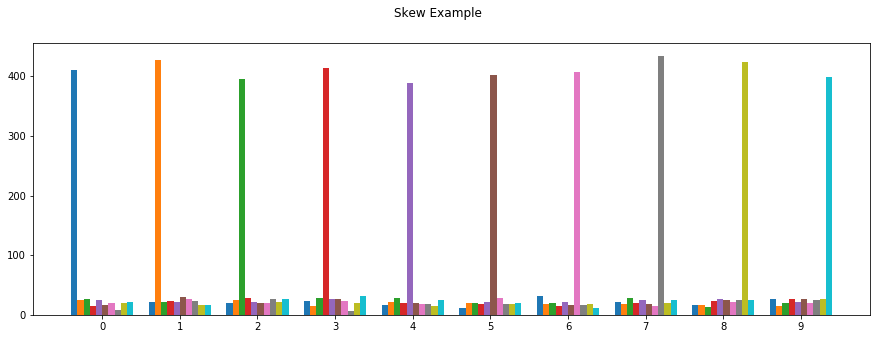

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(hist_counts, bins=range(11), histtype='bar', align='left', rwidth=0.8)

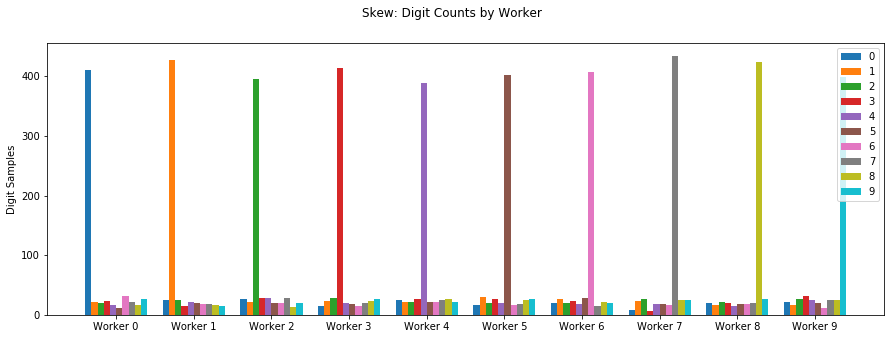

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew: Digit Counts by Worker')

pos = list(range(num_workers))
width = 0.08

for digit in range(len(digit_counts)):
    #print(digit)
    ax.bar([p + (width * digit) for p in pos],
           digit_counts[digit],
           width = width,
           label = str(digit),
          )

ax.set_xticks([p + (4.5 * width) for p in pos])
ax.set_xticklabels([('Worker ' + str(x)) for x in range(num_workers)])
ax.set_ylabel('Digit Samples')
ax.legend(loc = 'upper right');

We create the `federatedManager` using the skewed training data. Note that we don't skew the test data -- we want to see how everything performs on a normal data distribution.

In [21]:
import federated

run_data['Learning Rate'] = learning_rate = 3e-3
run_data['Epochs per Round'] = num_epochs = 1
run_data['Federated Training Rounds'] = num_rounds = 100

manager = federated.FederatedManager(
    stacked_data_loaders,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

Now let's do some rounds of federated training.

In [22]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.2f" % manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = manager.manager_loss_history
#run_data['Worker Loss Histories'] = manager.worker_loss_histories
run_data['Final Global Loss'] = manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])


  0%|          | 0/100 [00:00<?, ?it/s]

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.30
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.32



  1%|          | 1/100 [00:21<36:14, 21.96s/it]

Finished round 1 with global loss: 2.31 

Beginning round 2
	Worker: 6032 	local loss: 2.30
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.30
	Worker: 9656 	local loss: 2.26
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.27
	Worker: 9976 	local loss: 2.28
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.32



  2%|▏         | 2/100 [00:48<37:54, 23.21s/it]

Finished round 2 with global loss: 2.31 

Beginning round 3
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.32



  3%|▎         | 3/100 [01:14<38:59, 24.12s/it]

Finished round 3 with global loss: 2.31 

Beginning round 4
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.32



  4%|▍         | 4/100 [01:37<38:04, 23.80s/it]

Finished round 4 with global loss: 2.30 

Beginning round 5
	Worker: 6032 	local loss: 2.30
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



  5%|▌         | 5/100 [02:00<37:31, 23.70s/it]

Finished round 5 with global loss: 2.30 

Beginning round 6
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.28
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



  6%|▌         | 6/100 [02:27<38:22, 24.49s/it]

Finished round 6 with global loss: 2.30 

Beginning round 7
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.26
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



  7%|▋         | 7/100 [02:50<37:12, 24.01s/it]

Finished round 7 with global loss: 2.30 

Beginning round 8
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.33
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.30
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.27
	Worker: 6616 	local loss: 2.31



  8%|▊         | 8/100 [03:17<38:19, 24.99s/it]

Finished round 8 with global loss: 2.30 

Beginning round 9
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.32
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.28
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



  9%|▉         | 9/100 [03:39<36:36, 24.13s/it]

Finished round 9 with global loss: 2.30 

Beginning round 10
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.32
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



 10%|█         | 10/100 [04:03<36:19, 24.21s/it]

Finished round 10 with global loss: 2.30 

Beginning round 11
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.32
	Worker: 8440 	local loss: 2.33
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.27
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



 11%|█         | 11/100 [04:29<36:21, 24.51s/it]

Finished round 11 with global loss: 2.30 

Beginning round 12
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.32
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



 12%|█▏        | 12/100 [04:55<36:57, 25.20s/it]

Finished round 12 with global loss: 2.30 

Beginning round 13
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.32
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.29
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.31



 13%|█▎        | 13/100 [05:22<37:05, 25.58s/it]

Finished round 13 with global loss: 2.30 

Beginning round 14
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.31
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.27
	Worker: 6616 	local loss: 2.31



 14%|█▍        | 14/100 [05:43<34:47, 24.28s/it]

Finished round 14 with global loss: 2.30 

Beginning round 15
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.31
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 15%|█▌        | 15/100 [06:09<35:02, 24.73s/it]

Finished round 15 with global loss: 2.30 

Beginning round 16
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.31
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 16%|█▌        | 16/100 [06:27<31:51, 22.75s/it]

Finished round 16 with global loss: 2.30 

Beginning round 17
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.31
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.31



 17%|█▋        | 17/100 [06:45<29:41, 21.46s/it]

Finished round 17 with global loss: 2.29 

Beginning round 18
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.30
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 18%|█▊        | 18/100 [07:09<30:08, 22.06s/it]

Finished round 18 with global loss: 2.29 

Beginning round 19
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.30
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 19%|█▉        | 19/100 [07:25<27:20, 20.26s/it]

Finished round 19 with global loss: 2.29 

Beginning round 20
	Worker: 6032 	local loss: 2.29
	Worker: 7904 	local loss: 2.30
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 20%|██        | 20/100 [07:43<25:57, 19.47s/it]

Finished round 20 with global loss: 2.29 

Beginning round 21
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.29
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.27
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 21%|██        | 21/100 [08:04<26:31, 20.14s/it]

Finished round 21 with global loss: 2.29 

Beginning round 22
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.29
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.26
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 22%|██▏       | 22/100 [08:22<25:13, 19.40s/it]

Finished round 22 with global loss: 2.29 

Beginning round 23
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 23%|██▎       | 23/100 [08:40<24:21, 18.99s/it]

Finished round 23 with global loss: 2.29 

Beginning round 24
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.29
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.30



 24%|██▍       | 24/100 [09:00<24:31, 19.36s/it]

Finished round 24 with global loss: 2.29 

Beginning round 25
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.29



 25%|██▌       | 25/100 [09:18<23:30, 18.81s/it]

Finished round 25 with global loss: 2.29 

Beginning round 26
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.25
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.30



 26%|██▌       | 26/100 [09:40<24:33, 19.91s/it]

Finished round 26 with global loss: 2.29 

Beginning round 27
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.29



 27%|██▋       | 27/100 [10:01<24:21, 20.03s/it]

Finished round 27 with global loss: 2.29 

Beginning round 28
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 28%|██▊       | 28/100 [10:20<23:48, 19.85s/it]

Finished round 28 with global loss: 2.29 

Beginning round 29
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.28
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 29%|██▉       | 29/100 [10:39<23:16, 19.68s/it]

Finished round 29 with global loss: 2.29 

Beginning round 30
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.27
	Worker: 8440 	local loss: 2.32
	Worker: 5680 	local loss: 2.28
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 30%|███       | 30/100 [10:55<21:27, 18.39s/it]

Finished round 30 with global loss: 2.29 

Beginning round 31
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.27
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 31%|███       | 31/100 [11:11<20:30, 17.83s/it]

Finished round 31 with global loss: 2.28 

Beginning round 32
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.27
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.28



 32%|███▏      | 32/100 [11:31<20:44, 18.30s/it]

Finished round 32 with global loss: 2.28 

Beginning round 33
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.27
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.29



 33%|███▎      | 33/100 [11:50<20:54, 18.73s/it]

Finished round 33 with global loss: 2.28 

Beginning round 34
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.26
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 34%|███▍      | 34/100 [12:10<20:57, 19.05s/it]

Finished round 34 with global loss: 2.28 

Beginning round 35
	Worker: 6032 	local loss: 2.28
	Worker: 7904 	local loss: 2.27
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.26
	Worker: 9976 	local loss: 2.25
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.28



 35%|███▌      | 35/100 [12:36<22:51, 21.11s/it]

Finished round 35 with global loss: 2.28 

Beginning round 36
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.26
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.29



 36%|███▌      | 36/100 [12:53<21:19, 19.99s/it]

Finished round 36 with global loss: 2.28 

Beginning round 37
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.26
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 37%|███▋      | 37/100 [13:12<20:30, 19.54s/it]

Finished round 37 with global loss: 2.28 

Beginning round 38
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.26
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 38%|███▊      | 38/100 [13:31<20:04, 19.43s/it]

Finished round 38 with global loss: 2.28 

Beginning round 39
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.25
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 39%|███▉      | 39/100 [13:52<20:12, 19.87s/it]

Finished round 39 with global loss: 2.28 

Beginning round 40
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.25
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 40%|████      | 40/100 [14:14<20:32, 20.53s/it]

Finished round 40 with global loss: 2.28 

Beginning round 41
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.24
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 41%|████      | 41/100 [14:30<18:54, 19.24s/it]

Finished round 41 with global loss: 2.28 

Beginning round 42
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.25
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.28



 42%|████▏     | 42/100 [14:47<17:54, 18.52s/it]

Finished round 42 with global loss: 2.28 

Beginning round 43
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.24
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.24
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 43%|████▎     | 43/100 [15:06<17:45, 18.69s/it]

Finished round 43 with global loss: 2.28 

Beginning round 44
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.24
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.28



 44%|████▍     | 44/100 [15:22<16:43, 17.92s/it]

Finished round 44 with global loss: 2.27 

Beginning round 45
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.24
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.28



 45%|████▌     | 45/100 [15:41<16:37, 18.13s/it]

Finished round 45 with global loss: 2.27 

Beginning round 46
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.23
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.27
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.27



 46%|████▌     | 46/100 [16:01<16:43, 18.59s/it]

Finished round 46 with global loss: 2.27 

Beginning round 47
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.23
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.26
	Worker: 6616 	local loss: 2.27



 47%|████▋     | 47/100 [16:22<17:10, 19.45s/it]

Finished round 47 with global loss: 2.27 

Beginning round 48
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.23
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 48%|████▊     | 48/100 [16:40<16:35, 19.15s/it]

Finished round 48 with global loss: 2.27 

Beginning round 49
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.24
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.24
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 49%|████▉     | 49/100 [17:01<16:39, 19.59s/it]

Finished round 49 with global loss: 2.27 

Beginning round 50
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.23
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.27



 50%|█████     | 50/100 [17:19<15:51, 19.04s/it]

Finished round 50 with global loss: 2.27 

Beginning round 51
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.23
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.26
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 51%|█████     | 51/100 [17:35<14:54, 18.26s/it]

Finished round 51 with global loss: 2.27 

Beginning round 52
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 52%|█████▏    | 52/100 [17:52<14:15, 17.82s/it]

Finished round 52 with global loss: 2.27 

Beginning round 53
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.22
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.25
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 53%|█████▎    | 53/100 [18:12<14:24, 18.40s/it]

Finished round 53 with global loss: 2.27 

Beginning round 54
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 54%|█████▍    | 54/100 [18:28<13:39, 17.81s/it]

Finished round 54 with global loss: 2.27 

Beginning round 55
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.26



 55%|█████▌    | 55/100 [18:46<13:21, 17.81s/it]

Finished round 55 with global loss: 2.27 

Beginning round 56
	Worker: 6032 	local loss: 2.27
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.31
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 56%|█████▌    | 56/100 [19:06<13:29, 18.41s/it]

Finished round 56 with global loss: 2.27 

Beginning round 57
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 57%|█████▋    | 57/100 [19:23<12:58, 18.09s/it]

Finished round 57 with global loss: 2.27 

Beginning round 58
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.21
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.27



 58%|█████▊    | 58/100 [19:41<12:31, 17.90s/it]

Finished round 58 with global loss: 2.26 

Beginning round 59
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.20
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.26



 59%|█████▉    | 59/100 [20:00<12:28, 18.25s/it]

Finished round 59 with global loss: 2.26 

Beginning round 60
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.20
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.23
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.26



 60%|██████    | 60/100 [20:20<12:29, 18.73s/it]

Finished round 60 with global loss: 2.26 

Beginning round 61
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.19
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.26



 61%|██████    | 61/100 [20:36<11:48, 18.17s/it]

Finished round 61 with global loss: 2.26 

Beginning round 62
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.20
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.26



 62%|██████▏   | 62/100 [20:55<11:39, 18.40s/it]

Finished round 62 with global loss: 2.26 

Beginning round 63
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.19
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.26



 63%|██████▎   | 63/100 [21:14<11:18, 18.34s/it]

Finished round 63 with global loss: 2.26 

Beginning round 64
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.19
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.25



 64%|██████▍   | 64/100 [21:30<10:40, 17.80s/it]

Finished round 64 with global loss: 2.26 

Beginning round 65
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.20
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.26



 65%|██████▌   | 65/100 [21:48<10:20, 17.72s/it]

Finished round 65 with global loss: 2.26 

Beginning round 66
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.20
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.25
	Worker: 6616 	local loss: 2.25



 66%|██████▌   | 66/100 [22:08<10:33, 18.64s/it]

Finished round 66 with global loss: 2.26 

Beginning round 67
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.18
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.25



 67%|██████▋   | 67/100 [22:26<10:00, 18.20s/it]

Finished round 67 with global loss: 2.26 

Beginning round 68
	Worker: 6032 	local loss: 2.26
	Worker: 7904 	local loss: 2.19
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 68%|██████▊   | 68/100 [22:43<09:39, 18.10s/it]

Finished round 68 with global loss: 2.26 

Beginning round 69
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.18
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 69%|██████▉   | 69/100 [23:04<09:46, 18.93s/it]

Finished round 69 with global loss: 2.26 

Beginning round 70
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 70%|███████   | 70/100 [23:22<09:14, 18.49s/it]

Finished round 70 with global loss: 2.26 

Beginning round 71
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.19
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 71%|███████   | 71/100 [23:39<08:40, 17.95s/it]

Finished round 71 with global loss: 2.26 

Beginning round 72
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.25
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.24
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 72%|███████▏  | 72/100 [23:56<08:22, 17.94s/it]

Finished round 72 with global loss: 2.25 

Beginning round 73
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.23
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.21
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 73%|███████▎  | 73/100 [24:16<08:19, 18.52s/it]

Finished round 73 with global loss: 2.25 

Beginning round 74
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.22
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 74%|███████▍  | 74/100 [24:36<08:12, 18.93s/it]

Finished round 74 with global loss: 2.25 

Beginning round 75
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.16
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 75%|███████▌  | 75/100 [24:54<07:46, 18.64s/it]

Finished round 75 with global loss: 2.25 

Beginning round 76
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.18
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.25



 76%|███████▌  | 76/100 [25:15<07:45, 19.41s/it]

Finished round 76 with global loss: 2.25 

Beginning round 77
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.30
	Worker: 5680 	local loss: 2.24
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 77%|███████▋  | 77/100 [25:34<07:18, 19.06s/it]

Finished round 77 with global loss: 2.25 

Beginning round 78
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.18
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.25



 78%|███████▊  | 78/100 [25:54<07:08, 19.48s/it]

Finished round 78 with global loss: 2.25 

Beginning round 79
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.16
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 79%|███████▉  | 79/100 [26:17<07:09, 20.48s/it]

Finished round 79 with global loss: 2.25 

Beginning round 80
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.24



 80%|████████  | 80/100 [26:35<06:33, 19.65s/it]

Finished round 80 with global loss: 2.25 

Beginning round 81
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.15
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.26
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.24



 81%|████████  | 81/100 [26:55<06:20, 20.01s/it]

Finished round 81 with global loss: 2.25 

Beginning round 82
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.14
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 82%|████████▏ | 82/100 [27:15<05:56, 19.79s/it]

Finished round 82 with global loss: 2.25 

Beginning round 83
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.23
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 83%|████████▎ | 83/100 [27:33<05:28, 19.30s/it]

Finished round 83 with global loss: 2.25 

Beginning round 84
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.16
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.23



 84%|████████▍ | 84/100 [27:57<05:32, 20.78s/it]

Finished round 84 with global loss: 2.25 

Beginning round 85
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.15
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.24



 85%|████████▌ | 85/100 [28:20<05:20, 21.40s/it]

Finished round 85 with global loss: 2.24 

Beginning round 86
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.17
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 86%|████████▌ | 86/100 [28:39<04:49, 20.69s/it]

Finished round 86 with global loss: 2.24 

Beginning round 87
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.14
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 87%|████████▋ | 87/100 [28:58<04:21, 20.09s/it]

Finished round 87 with global loss: 2.24 

Beginning round 88
	Worker: 6032 	local loss: 2.24
	Worker: 7904 	local loss: 2.14
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 88%|████████▊ | 88/100 [29:16<03:54, 19.52s/it]

Finished round 88 with global loss: 2.24 

Beginning round 89
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 89%|████████▉ | 89/100 [29:33<03:28, 18.93s/it]

Finished round 89 with global loss: 2.24 

Beginning round 90
	Worker: 6032 	local loss: 2.22
	Worker: 7904 	local loss: 2.14
	Worker: 8440 	local loss: 2.27
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 90%|█████████ | 90/100 [29:51<03:04, 18.42s/it]

Finished round 90 with global loss: 2.24 

Beginning round 91
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.29
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.24



 91%|█████████ | 91/100 [30:11<02:51, 19.08s/it]

Finished round 91 with global loss: 2.24 

Beginning round 92
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.14
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.23



 92%|█████████▏| 92/100 [30:28<02:26, 18.25s/it]

Finished round 92 with global loss: 2.24 

Beginning round 93
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.20
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.22



 93%|█████████▎| 93/100 [30:45<02:05, 17.86s/it]

Finished round 93 with global loss: 2.24 

Beginning round 94
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.13
	Worker: 8440 	local loss: 2.27
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 94%|█████████▍| 94/100 [31:01<01:44, 17.45s/it]

Finished round 94 with global loss: 2.24 

Beginning round 95
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.23
	Worker: 9656 	local loss: 2.22
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.21
	Worker: 6616 	local loss: 2.23



 95%|█████████▌| 95/100 [31:18<01:26, 17.33s/it]

Finished round 95 with global loss: 2.24 

Beginning round 96
	Worker: 6032 	local loss: 2.25
	Worker: 7904 	local loss: 2.11
	Worker: 8440 	local loss: 2.27
	Worker: 5680 	local loss: 2.21
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.22
	Worker: 6616 	local loss: 2.22



 96%|█████████▌| 96/100 [31:35<01:08, 17.11s/it]

Finished round 96 with global loss: 2.24 

Beginning round 97
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.27
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 97%|█████████▋| 97/100 [31:51<00:50, 16.99s/it]

Finished round 97 with global loss: 2.24 

Beginning round 98
	Worker: 6032 	local loss: 2.23
	Worker: 7904 	local loss: 2.10
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.25
	Worker: 1952 	local loss: 2.22
	Worker: 9976 	local loss: 2.19
	Worker: 3760 	local loss: 2.24
	Worker: 6616 	local loss: 2.22



 98%|█████████▊| 98/100 [32:11<00:35, 17.85s/it]

Finished round 98 with global loss: 2.23 

Beginning round 99
	Worker: 6032 	local loss: 2.22
	Worker: 7904 	local loss: 2.12
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.21
	Worker: 9656 	local loss: 2.21
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.17
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.23



 99%|█████████▉| 99/100 [32:26<00:16, 16.87s/it]

Finished round 99 with global loss: 2.23 

Beginning round 100
	Worker: 6032 	local loss: 2.22
	Worker: 7904 	local loss: 2.11
	Worker: 8440 	local loss: 2.28
	Worker: 5680 	local loss: 2.22
	Worker: 9656 	local loss: 2.20
	Worker: 3888 	local loss: 2.24
	Worker: 1952 	local loss: 2.21
	Worker: 9976 	local loss: 2.18
	Worker: 3760 	local loss: 2.23
	Worker: 6616 	local loss: 2.22



100%|██████████| 100/100 [32:43<00:00, 16.81s/it]

Finished round 100 with global loss: 2.23 

Federated Training Time: 1963.02


Now let's take a look at how the training went. Here's a graph of the loss per round.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

This looks pretty good, with loss dropping off just like we want. Perhaps it's a little bumpy because of the relatively fast training rate, but it should be improving on balance. But if we look under the hood at each individual worker's loss, we see that the workers' local models are diverging and converging at each round. They diverge because each local model trains on different data, resulting in a somewhat different loss per round. The converge again because the manager combines them into a master model, such that they all have the same loss as the global loss.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))


for i in range(len(manager.worker_loss_histories)):
    ax.plot(manager.worker_loss_histories[i], label=('Worker ' + str(i)))

# TODO: Align the global loss properly
ax.plot(manager.manager_loss_history[1], label="Global Loss", )

    
# TODO: Get these labels done properly - they should be aligned with the main 
ax.set_xticklabels([(i-1) for i in range(len(manager.worker_loss_histories))])
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Well. I did this. And now the code is unreadable.

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?

- TODO: unequal data volume at each worker. Try some workers with very small or very large samples.

In [ ]:
# a little performance info on the run
run_data['Global End Time'] = time.time()
run_data['Global Time'] = run_data['Global End Time'] - run_data['Global Start Time']
run_data

In [ ]:
# leave a record of the run
# but it isn't valid JSON
import json 
with open('run_data.json', 'a') as file:
    file.write(json.dumps(run_data))
    file.write('\n\n')

In [ ]:
from collections import Counter
import numpy as np

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train digit counts: \n", train_counts)
print("Train count standard deviation: %.2f" % np.std(list(zip(*train_counts))[1]))
print("Train count coefficient of variation: %.2f" 
      % (float(np.mean(list(zip(*train_counts))[1])) / float(np.std(list(zip(*train_counts))[1]))))

print()

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test digit counts: \n", test_counts)
print("Test standard deviation: %.2f" % np.std(list(zip(*test_counts))[1]))
print("Test count coefficient of variation: %.2f" 
      % (float(np.mean(list(zip(*test_counts))[1])) / float(np.std(list(zip(*test_counts))[1]))))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Counts at each Worker')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels([('Digit ' + str(x-1)) for x in range(11)])
ax.hist(hist_counts, 
        label=[('Worker ' + str(x)) for x in range(num_workers)],
        bins=list(range(12)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       );
ax.legend();